In [1]:
# import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [15]:
# load data
train_df = pd.read_pickle("../data/train.pickle")
val_df   = pd.read_pickle("../data/val.pickle")

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()

train_user_ids = train_df["user_id"].tolist()
val_user_ids   = val_df["user_id"].tolist()

y_train = train_df[["valence", "arousal"]].values.astype(float)
y_val   = val_df[["valence", "arousal"]].values.astype(float)


In [16]:
# compute embeddings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

X_train = encoder.encode(
    train_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

X_val = encoder.encode(
    val_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(X_train.shape, X_val.shape)

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(2211, 384) (553, 384)


In [17]:
# define MLP-based model

class MLPModel(nn.Module):
    def __init__(self, embedding_dim=384, num_users=1000, user_embedding_dim=32, hidden_dim=512):
        super(MLPModel, self).__init__()
        
        # User embedding - use actual number of users
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = embedding + user embedding
        input_dim = embedding_dim + user_embedding_dim
        
        # MLP layers with extra hidden layer: [input → 512 → 256 → 128 → 2]
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, 2)  # Predict valence and arousal
        
    def forward(self, x_embed, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)  # (batch_size, user_embedding_dim)
        
        # Concatenate embedding and user embedding
        combined = torch.cat([x_embed, user_embed], dim=1)  # (batch_size, embedding_dim + user_embedding_dim)
        
        # MLP layers: [input → 512 → 256 → 128 → 2]
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Convert user_ids to tensors (adjust user IDs to be 0-indexed)
user_id_map = {}
train_user_id_list = []
for uid in train_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    train_user_id_list.append(user_id_map[uid])

val_user_id_list = []
for uid in val_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    val_user_id_list.append(user_id_map[uid])

train_user_ids_tensor = torch.tensor(train_user_id_list, dtype=torch.long).to(device)
val_user_ids_tensor = torch.tensor(val_user_id_list, dtype=torch.long).to(device)

num_unique_users = len(user_id_map)
print(f"Number of unique users: {num_unique_users}")


Using device: cuda
Number of unique users: 137


In [ ]:
# train MLP model with early stopping
model = MLPModel(embedding_dim=384, num_users=num_unique_users, user_embedding_dim=32, hidden_dim=512)
model = model.to(device)

# Initialize weights
for name, param in model.named_parameters():
    if 'weight' in name and param.dim() > 1:
        nn.init.xavier_uniform_(param, gain=0.5)
    elif 'bias' in name:
        nn.init.zeros_(param)
    elif 'user_embedding' in name:
        nn.init.normal_(param, mean=0, std=0.01)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
num_epochs = 100  # Max epochs, but may stop early
batch_size = 32
best_val_loss = float('inf')
patience = 5  # Number of epochs with no improvement to wait before stopping
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_x = X_train_tensor[i:i+batch_size]
        batch_user_ids = train_user_ids_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        predictions = model(batch_x, batch_user_ids)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= (len(X_train_tensor) // batch_size)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor, val_user_ids_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0 or (epoch + 1) == 1:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Patience: {patience_counter}/{patience}")
    
    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0  # Reset patience counter
        
    else:
        patience_counter += 1
    
    # Stop training if patience exceeded
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        break

print(f"Training completed! Total epochs: {epoch+1}/{num_epochs}")


Epoch 1, Train Loss: 0.9002, Val Loss: 0.6535, Patience: 0/5
Epoch 10, Train Loss: 0.2947, Val Loss: 0.5896, Patience: 3/5

Early stopping triggered at epoch 11
Best validation loss: 0.5362
Training completed! Total epochs: 11/100


In [12]:
# evaluate model performance
model.load_state_dict(torch.load("best_attention_model.pt"))
model.eval()

with torch.no_grad():
    train_predictions = model(X_train_tensor, train_user_ids_tensor)
    val_predictions = model(X_val_tensor, val_user_ids_tensor)

# Convert to numpy
train_preds_np = train_predictions.cpu().numpy()
val_preds_np = val_predictions.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
y_val_np = y_val_tensor.cpu().numpy()

# Calculate metrics
train_mse = mean_squared_error(y_train_np, train_preds_np)
train_mae = mean_absolute_error(y_train_np, train_preds_np)
val_mse = mean_squared_error(y_val_np, val_preds_np)
val_mae = mean_absolute_error(y_val_np, val_preds_np)

print("=" * 50)
print("ATTENTION MODEL PERFORMANCE")
print("=" * 50)
print(f"Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Val MSE:   {val_mse:.4f}, Val MAE:   {val_mae:.4f}")

# Per-dimension metrics
train_mse_valence = mean_squared_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mse_arousal = mean_squared_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mse_valence = mean_squared_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mse_arousal = mean_squared_error(y_val_np[:, 1], val_preds_np[:, 1])

print(f"\nValence - Train MSE: {train_mse_valence:.4f}, Val MSE: {val_mse_valence:.4f}")
print(f"Arousal  - Train MSE: {train_mse_arousal:.4f}, Val MSE: {val_mse_arousal:.4f}")


ATTENTION MODEL PERFORMANCE
Train MSE: 0.3700, Train MAE: 0.4655
Val MSE:   0.5481, Val MAE:   0.5553

Valence - Train MSE: 0.4808, Val MSE: 0.7101
Arousal  - Train MSE: 0.2592, Val MSE: 0.3862


/tmp/ipykernel_15607/73099331.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_attention_model.pt"))


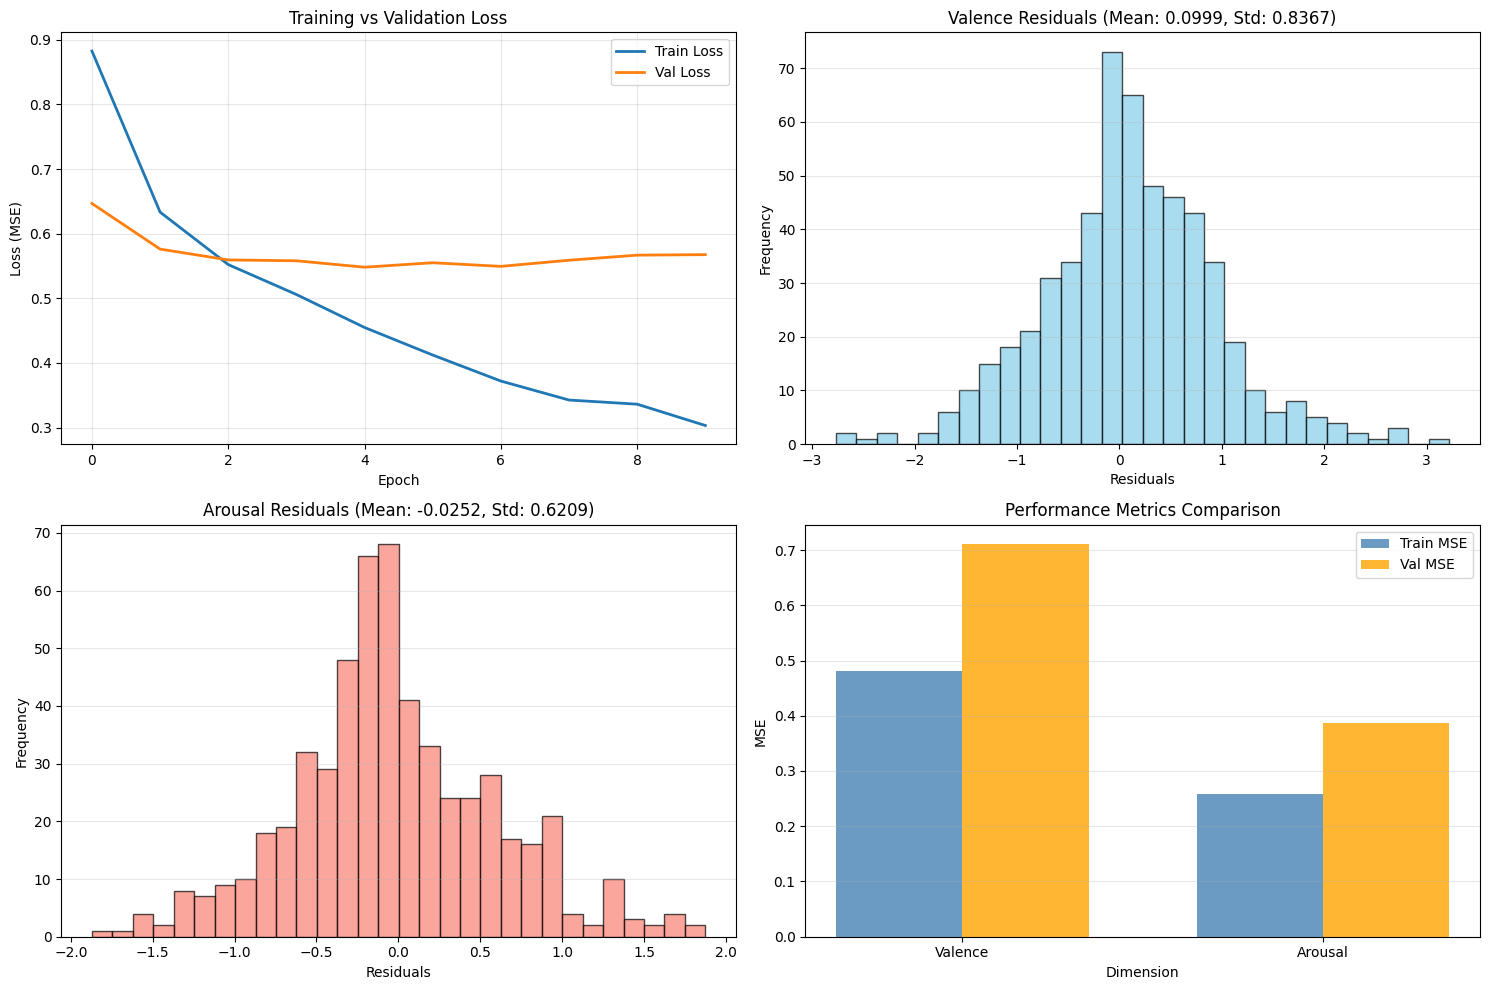

In [ ]:
# comprehensive 4-panel visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Training vs Validation Loss
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Panel 2: Valence Residuals
val_residuals_valence = y_val_np[:, 0] - val_preds_np[:, 0]
axes[0, 1].hist(val_residuals_valence, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Valence Residuals (Mean: {np.mean(val_residuals_valence):.4f}, Std: {np.std(val_residuals_valence):.4f})')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Panel 3: Arousal Residuals
val_residuals_arousal = y_val_np[:, 1] - val_preds_np[:, 1]
axes[1, 0].hist(val_residuals_arousal, bins=30, alpha=0.7, edgecolor='black', color='salmon')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Arousal Residuals (Mean: {np.mean(val_residuals_arousal):.4f}, Std: {np.std(val_residuals_arousal):.4f})')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Panel 4: Performance Metrics Comparison (MSE + MAE)
# Calculate MAE metrics
train_mae_valence = mean_absolute_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mae_arousal = mean_absolute_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mae_valence = mean_absolute_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mae_arousal = mean_absolute_error(y_val_np[:, 1], val_preds_np[:, 1])

metrics = ['Valence\nMSE', 'Arousal\nMSE', 'Valence\nMAE', 'Arousal\nMAE']
train_vals = [train_mse_valence, train_mse_arousal, train_mae_valence, train_mae_arousal]
val_vals = [val_mse_valence, val_mse_arousal, val_mae_valence, val_mae_arousal]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='steelblue')
axes[1, 1].bar(x + width/2, val_vals, width, label='Val', alpha=0.8, color='orange')
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Error Value')
axes[1, 1].set_title('Performance Metrics Comparison (MSE & MAE)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()